In [36]:
import numpy as np 
import os
from six.moves import cPickle
import matplotlib.pyplot as pl
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import scale
import timeit
from sklearn.metrics import recall_score,precision_score,confusion_matrix
import pandas as pd

In [125]:
'''
load the data from cifar100 file
    data_train: 50000*3072,3072 = 3*32*32 pixels
    label_train: 50000
    data_test:10000*3072
    label_test:10000
'''
def unpickle(file): 
    #load the data
    file = os.path.join(path,file)
    fo = open(file, 'rb')  
    dict = cPickle.load(fo,encoding='latin-1')  
    fo.close()  
    return dict 

def load_cifar100():
    cifar100_train = unpickle('train')
    data_train = cifar100_train['data']  
    label_train = cifar100_train['fine_labels']
    cifar100_test = unpickle('test')
    data_test = cifar100_test['data']  
    label_test = cifar100_test['fine_labels']
    className = unpickle('meta')['fine_label_names']
    return data_train, label_train,data_test,label_test,className

path  = '/Users/chaizhizhi/Desktop/load_cifar/cifar-100-python/'
data_train, label_train,data_test,label_test,className = load_cifar100()

In [3]:
#show 100 classes
print(className)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

Train data


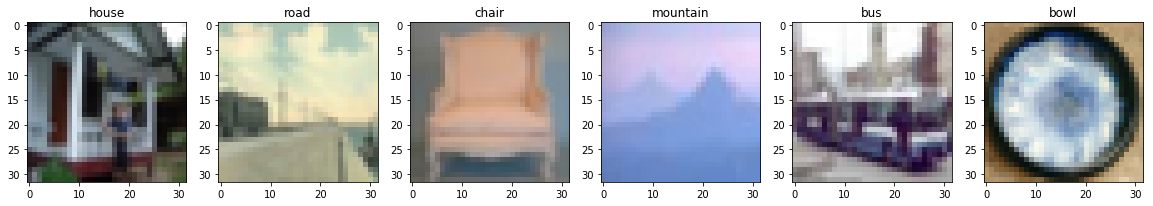

Test data


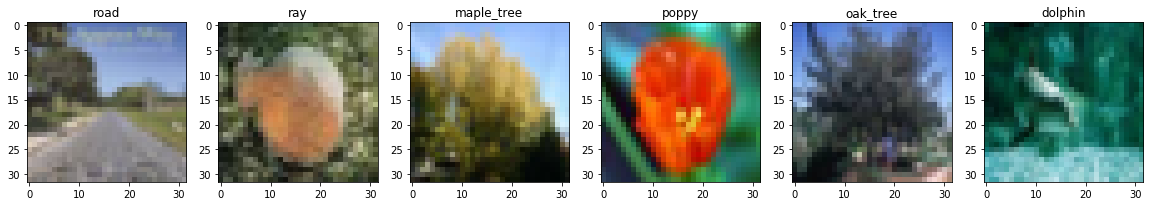

In [4]:
'''
randomly show the sample image 
'''
pl.figure(figsize =(20,10))
print('Train data')
sample = np.random.randint(0,50000,size = 8)
for i in range(1,7):
    pl.subplot(2,6,i)
    pl.title(className[label_train[sample[i]]])
    pl.imshow(np.transpose(data_train[sample[i]].reshape(3,32,32), (1, 2, 0)), interpolation='nearest')
pl.show()

pl.figure(figsize =(20,10))
print('Test data')
sample = np.random.randint(0,10000,size = 8)
for i in range(1,7):
    pl.subplot(1,6,i)
    pl.title(className[label_test[sample[i]]])
    pl.imshow(np.transpose(data_test[sample[i]].reshape(3,32,32), (1, 2, 0)), interpolation='nearest')
pl.show()

In [5]:
'''
Process the data using standarization and Principal Component Analysis(PCA)
    Parameters:
                    nd: n_components to control the reduction dimensions
'''

def Process(nd):
    pca = PCA(n_components = nd)
    pca_train = scale(pca.fit_transform(data_train))
    pca_test = scale(pca.transform(data_test))
    return pca_train,pca_test


In [135]:
'''
10-fold cross validation by using LOOCV
not considered
'''
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
label_train_reshape = np.asarray(label_train)
pca_train_data, pca_test_data = Process(60) 
score = []
for train,test in kf.split(label_train):
    x_train = pca_train_data[train]
    x_label = label_train_reshape[train]
    clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    clf.fit(x_train,x_label)
    score.append(clf.score(pca_test_data,label_test))
print(socre)

In [151]:
'''
10-fold validation with 10-fold cross validation with average accuracy
'''
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

pca_train_data, pca_test_data = Process(60) 
validation_set = np.vstack((pca_train_data,pca_test_data))
validation_label = np.concatenate((label_train,label_test),axis=0)
scoring = ['precision_macro', 'recall_macro']
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
scores = cross_val_score(clf, validation_set, validation_label, cv=cv)

[0.30383333 0.29083333 0.29166667 0.29233333 0.29083333 0.30366667
 0.29633333 0.30266667 0.29083333 0.29083333]


In [152]:
#print the average accuray of cross validation
print(scores.mean())

0.2953833333333334


In [156]:
'''
Out put the 10-fold validation SVM with precision ,recall
'''
from sklearn.model_selection import cross_validate

clf.fit(pca_train_data,label_train) #fit the train data with fine label
scoring = ['precision_macro', 'recall_macro']
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-n1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)

scores = cross_validate(clf, validation_set, validation_label,scoring=scoring, cv=cv,return_train_score=False)
print("Total time :", timeit.default_timer() - start_time , 's')
sorted(scores.keys())

Total time : 21038.769905035035 s


['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']

In [158]:
print('Precision: ',scores['test_precision_macro'].mean())
print('Recall: ',scores['test_precision_macro'].mean())

Precision:  0.30011914291553027
Recall:  0.30011914291553027


In [32]:
'''
Polynomial Kernel SVM 
Tuning parameters of PCA n_components 60-120
'''

def Process(nd):
    pca = PCA(n_components = nd)
    pca_train = scale(pca.fit_transform(data_train))
    pca_test = scale(pca.transform(data_test))
    return pca_train,pca_test

#train the model with PCA
bound = 50000
for i in range(2,60,5):
        pca_train_data, pca_test_data = Process(i) 
        #set parameters of SVM: kernel, gamma
        clf = SVC(C=20.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
        #fit and predcit
        start_time = timeit.default_timer() 
        clf.fit(pca_train_data[0:bound],label_train[0:bound]) #fit the train data with fine label
        # predict = clf.predict(pca_test_data)
        print('PCA components:' ,i,"  Accuracy: ",clf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

PCA components: 2   Accuracy:  0.0377 Total time : 400.65695111907553 s
PCA components: 7   Accuracy:  0.1241 Total time : 476.86309261992574 s
PCA components: 12   Accuracy:  0.166 Total time : 274.8807404669933 s
PCA components: 17   Accuracy:  0.2008 Total time : 191.8564768540673 s
PCA components: 22   Accuracy:  0.2249 Total time : 195.92023797507863 s
PCA components: 27   Accuracy:  0.229 Total time : 216.1713682130212 s
PCA components: 32   Accuracy:  0.2279 Total time : 238.14635447098408 s
PCA components: 37   Accuracy:  0.2325 Total time : 274.8409335189499 s
PCA components: 42   Accuracy:  0.2323 Total time : 304.9381345199654 s
PCA components: 47   Accuracy:  0.2407 Total time : 336.67491942399647 s
PCA components: 52   Accuracy:  0.2423 Total time : 382.1485369099537 s
PCA components: 57   Accuracy:  0.2412 Total time : 416.2104539909633 s


In [97]:
'''
RBF kernel SVM
Tuning parameters of PCA n_components 60-120
'''

#train the model with PCA

for i in range(60,150,10):
        pca_train_data, pca_test_data = Process(i) 
        #set parameters of SVM: kernel, gamma
        clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
        start_time = timeit.default_timer() 
        clf.fit(pca_train_data,label_train) #fit the train data with fine label
        print('PCA components:' ,i,"  Accuracy: ",clf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

PCA components: 60   Accuracy:  0.2943 Total time : 431.07987725303974 s
PCA components: 70   Accuracy:  0.2918 Total time : 477.49841943895444 s
PCA components: 80   Accuracy:  0.2887 Total time : 537.6003056420013 s
PCA components: 90   Accuracy:  0.29 Total time : 593.3284824880539 s
PCA components: 100   Accuracy:  0.2821 Total time : 654.8642843349371 s
PCA components: 110   Accuracy:  0.2838 Total time : 709.1390152720269 s
PCA components: 120   Accuracy:  0.2849 Total time : 769.1991628049873 s
PCA components: 130   Accuracy:  0.274 Total time : 824.681765495101 s
PCA components: 140   Accuracy:  0.2759 Total time : 886.1188929619966 s


In [103]:
#choose the best one make prediction
pca_train_data, pca_test_data = Process(60) 
#set parameters of SVM: kernel, gamma
clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
max_iter=-1, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
#fit and predcit
start_time = timeit.default_timer() 
clf.fit(pca_train_data,label_train) #fit the train data with fine label
rSVMpredict = clf.predict(pca_test_data)
print('PCA components:' ,i,"  Accuracy: ",clf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

PCA components: 50   Accuracy:  0.2951 Total time : 547.2262616270455 s


In [154]:
'''
Output confusion matrix for SVM
'''

cnf = confusion_matrix(rSVMpredict,label_test)

# classes =pd.DataFrame(className,)
# cnf = pd.concat([className,cnf],axis=0)
cnf = pd.DataFrame(cnf,index= className,columns= className)

writer = ExcelWriter('SVM_confusion_matrix.xlsx')
cnf.to_excel(writer,'Sheet1')
writer.save()

In [99]:
'''
Output the RBF kernel result
'''

#train the model with PCA


pca_train_data, pca_test_data = Process(60) 
#set parameters of SVM: kernel, gamma
clf = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
max_iter=-1, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
#fit and predcit
start_time = timeit.default_timer() 
clf.fit(pca_train_data,label_train) #fit the train data with fine label
svcPredict = clf.predict(pca_test_data)
print('PCA components:' ,i,"  Accuracy: ",clf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

PCA components: 50   Accuracy:  0.2913 Total time : 439.97724118991755 s


In [44]:
'''
Randomforest 
Tuning PCA parameters
'''
from sklearn.ensemble import RandomForestClassifier
for i in range(10,200,5):
        pca_train_data,pca_test_data = Process(i)
        rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                    max_depth=2, max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
                    oob_score=None, random_state=0, verbose=0, warm_start=False)
        start_time = timeit.default_timer() 
        rdfClf.fit(pca_train_data,label_train) 
        # rdfPredict = rdfClf.predict(pca_test_data)
        print("PCA: ",i," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

PCA:  10  Accuracy:  0.0646 Total time : 7.293836163938977 s
PCA:  15  Accuracy:  0.0773 Total time : 7.780267638969235 s
PCA:  20  Accuracy:  0.0791 Total time : 9.437186802038923 s
PCA:  25  Accuracy:  0.0773 Total time : 10.960885170963593 s
PCA:  30  Accuracy:  0.0817 Total time : 12.24872046802193 s
PCA:  35  Accuracy:  0.0868 Total time : 10.49430607596878 s
PCA:  40  Accuracy:  0.0829 Total time : 13.35140963701997 s
PCA:  45  Accuracy:  0.0909 Total time : 13.801764333969913 s
PCA:  50  Accuracy:  0.0876 Total time : 14.23861063097138 s
PCA:  55  Accuracy:  0.0886 Total time : 14.29045013396535 s
PCA:  60  Accuracy:  0.0918 Total time : 13.70983668207191 s
PCA:  65  Accuracy:  0.0901 Total time : 15.563149507972412 s
PCA:  70  Accuracy:  0.0916 Total time : 15.766637853928842 s
PCA:  75  Accuracy:  0.0945 Total time : 15.700099154026248 s
PCA:  80  Accuracy:  0.0933 Total time : 16.154900948051363 s
PCA:  85  Accuracy:  0.0947 Total time : 17.694876505993307 s
PCA:  90  Accurac

In [46]:
'''
Randomforest 
Tuning the parameters n_estimators
'''
from sklearn.ensemble import RandomForestClassifier
for i in range(500,1000,100):
        pca_train_data,pca_test_data = Process(195)
        rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                    max_depth=2, max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=4,
                    oob_score=None, random_state=0, verbose=0, warm_start=False)
        start_time = timeit.default_timer() 
        rdfClf.fit(pca_train_data,label_train) 
        # rdfPredict = rdfClf.predict(pca_test_data)
        print("n_estimators: ",i," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

n_estimators:  500  Accuracy:  0.0986 Total time : 34.73370205005631 s
n_estimators:  600  Accuracy:  0.0982 Total time : 44.6939018300036 s
n_estimators:  700  Accuracy:  0.0972 Total time : 41.80667945602909 s
n_estimators:  800  Accuracy:  0.0977 Total time : 47.10047398600727 s
n_estimators:  900  Accuracy:  0.0973 Total time : 55.82792330801021 s


In [50]:
'''
Randomforest 
Max_depth
'''
from sklearn.ensemble import RandomForestClassifier
for i in range(5,20):
    pca_train_data,pca_test_data = Process(195)
    rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=i, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=5, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
                oob_score=None, random_state=0, verbose=0, warm_start=False)
    start_time = timeit.default_timer() 
    rdfClf.fit(pca_train_data,label_train) 
    # rdfPredict = rdfClf.predict(pca_test_data)
    print("n_estimators: ",i," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

n_estimators:  5  Accuracy:  0.1319 Total time : 70.51435793901328 s
n_estimators:  6  Accuracy:  0.142 Total time : 66.85496837389655 s
n_estimators:  7  Accuracy:  0.1554 Total time : 75.17504301003646 s
n_estimators:  8  Accuracy:  0.1669 Total time : 86.79390446702018 s
n_estimators:  9  Accuracy:  0.1728 Total time : 114.52445011108648 s
n_estimators:  10  Accuracy:  0.1826 Total time : 125.84253545699175 s
n_estimators:  11  Accuracy:  0.189 Total time : 115.85004096396733 s
n_estimators:  12  Accuracy:  0.1947 Total time : 147.0460514209699 s
n_estimators:  13  Accuracy:  0.2029 Total time : 132.08434304001275 s
n_estimators:  14  Accuracy:  0.2076 Total time : 143.66768548206892 s
n_estimators:  15  Accuracy:  0.2134 Total time : 149.2908946640091 s
n_estimators:  16  Accuracy:  0.2188 Total time : 159.3106434670044 s
n_estimators:  17  Accuracy:  0.223 Total time : 193.64260750601534 s
n_estimators:  18  Accuracy:  0.2239 Total time : 171.35844653099775 s
n_estimators:  19  Ac

In [55]:
'''
Randomforest 
Max_depth
'''
from sklearn.ensemble import RandomForestClassifier
for i in range(20,40):
    pca_train_data,pca_test_data = Process(195)
    rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=i, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=5, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
                oob_score=None, random_state=0, verbose=0, warm_start=False)
    start_time = timeit.default_timer() 
    rdfClf.fit(pca_train_data,label_train) 
    # rdfPredict = rdfClf.predict(pca_test_data)
    print('Max_depth: ' ,i," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

Max_depth:  20  Accuracy:  0.2313 Total time : 171.73337348096538 s
Max_depth:  21  Accuracy:  0.2325 Total time : 179.03167752397712 s
Max_depth:  22  Accuracy:  0.2342 Total time : 184.49632556305733 s
Max_depth:  23  Accuracy:  0.2358 Total time : 189.66395190905314 s
Max_depth:  24  Accuracy:  0.2349 Total time : 192.40311575797386 s
Max_depth:  25  Accuracy:  0.2404 Total time : 195.75709379801992 s
Max_depth:  26  Accuracy:  0.2373 Total time : 203.69585670309607 s
Max_depth:  27  Accuracy:  0.2397 Total time : 232.6011682690587 s
Max_depth:  28  Accuracy:  0.2381 Total time : 227.4471007650718 s
Max_depth:  29  Accuracy:  0.2428 Total time : 201.21777203504462 s
Max_depth:  30  Accuracy:  0.2394 Total time : 206.4425695729442 s
Max_depth:  31  Accuracy:  0.2442 Total time : 211.5447014690144 s
Max_depth:  32  Accuracy:  0.2408 Total time : 215.34981069306377 s
Max_depth:  33  Accuracy:  0.2395 Total time : 223.37284514296334 s
Max_depth:  34  Accuracy:  0.2403 Total time : 214.9

In [13]:
'''
Randomforest 
Max_depth
'''
from sklearn.ensemble import RandomForestClassifier

pca_train_data,pca_test_data = Process(130)
rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=None, random_state=0, verbose=0, warm_start=False)
start_time = timeit.default_timer() 
rdfClf.fit(pca_train_data,label_train) 
rdfPredict = rdfClf.predict(pca_test_data)
print('n_estimator: ' ,2000," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

n_estimator:  2000  Accuracy:  0.2545 Total time : 420.03147492103744 s


In [32]:
'''
Recall and precision of randomforest
'''
print('Recall of random forest: ' ,(recall_score(rdfPredict,label_test,average = 'macro')))
print('Precision of random forest:', (precision_score(rdfPredict,label_test,average = 'macro')))

Recall of random forest:  0.26531061743314915
Precision of random forest: 0.2545


In [96]:
'''
Output confusion matrix for RF
'''
cnf = confusion_matrix(rdfPredict,label_test)

# classes =pd.DataFrame(className,)
# cnf = pd.concat([className,cnf],axis=0)
cnf = pd.DataFrame(cnf,index= className,columns= className)

writer = ExcelWriter('Random_Forest_Confusion.xlsx')
cnf.to_excel(writer,'Sheet1')
writer.save()






Use Lenet-5 to get features




In [102]:
'''
Randomforest 
Max_depth
'''
from sklearn.ensemble import RandomForestClassifier

pca_train_data,pca_test_data = Process(130)
rdfClf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=None, random_state=0, verbose=0, warm_start=False)
start_time = timeit.default_timer() 
rdfClf.fit(pca_train_data,label_train) 
rdfPredict = rdfClf.predict(pca_test_data)
print('n_estimator: ' ,2000," Accuracy: ",rdfClf.score(pca_test_data,label_test), "Total time :", timeit.default_timer() - start_time , 's')

n_estimator:  2000  Accuracy:  0.2439 Total time : 1194.1783079151064 s


In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [44]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
'''
Train the network using lenet-5 model
'''
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (data, target) in enumerate(trainloader):
        inputs, labels = Variable(data), Variable(target, requires_grad=False)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i  == 49999:  
            print('Epoch:',epoch,'  running loss:',running_loss/50000)

Epoch: 0   running loss: 4.058277606234551
Epoch: 1   running loss: 3.765403175253868
Epoch: 2   running loss: 3.698160364112854
Epoch: 3   running loss: 3.6766901392173765
Epoch: 4   running loss: 3.6714144670820237
Epoch: 5   running loss: 3.6473697448444367
Epoch: 6   running loss: 3.655264813323021
Epoch: 7   running loss: 3.657155130596161
Epoch: 8   running loss: 3.657190018577576
Epoch: 9   running loss: 3.670177581744194
Epoch: 10   running loss: 3.6685367511701585
Epoch: 11   running loss: 3.6611583693885805
Epoch: 12   running loss: 3.677549106383324
Epoch: 13   running loss: 3.6859103056287768
Epoch: 14   running loss: 3.6869292206525803
Epoch: 15   running loss: 3.6771988095617294
Epoch: 16   running loss: 3.7064144478178025
Epoch: 17   running loss: 3.6890145743989944
Epoch: 18   running loss: 3.703132974410057
Epoch: 19   running loss: 3.6991055021095276
Finished Training


In [46]:
'''
output the accuracy
'''
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 13 %


In [47]:
'''
Consider to use the lenet-5 to extract features from dataset
'''
class feature(nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self) 
        modules = list(net.children())[:-3]     
        self.conv = nn.Sequential(*modules) #load the model
        self.fc1 =  nn.Linear(16 * 5 * 5, 120)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        return x

In [48]:
#get the feature using letnet-5
extractor = feature()
out  = torch.empty((50000,480))
j=0
for i, (data, target) in enumerate(trainloader,0):
        inputs, labels = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        out[j]= extractor(inputs).view(1,-1)
        j+=1
featureTrain = out.detach().numpy()

In [49]:
#get the feature using letnet-5
extractor = feature()
out_test  = torch.empty((10000,480))
j=0
for data in testloader:
    images, labels = data
    out_test[j]= extractor(images).view(1,-1)
    j+=1
featureTest = out_test.detach().numpy()

In [51]:
'''
Not acceptable result
'''
bound = 50000
#set parameters of SVM: kernel, gamma
clf = SVC(C=20.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
#fit and predcit
start_time = timeit.default_timer() 
clf.fit(featureTrain[0:bound],label_train[0:bound]) #fit the train data with fine label
# predict = clf.predict(pca_test_data)
print("  Accuracy: ",clf.score(featureTest,label_test), "Total time :", timeit.default_timer() - start_time , 's')

  Accuracy:  0.0102 Total time : 8899.575949272024 s
